# Trying to generate Music with JSBChorales using VAE

In [54]:
import torch
import torch.nn as nn
from torch.optim import Adam

import numpy as np
import matplotlib.pyplot as plt
import joblib
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [55]:
datas = joblib.load("/kaggle/input/holedbach/jsb1-li-train.pkl")
X = datas['X']
X = X.reshape(X.shape[0], 1, X.shape[1], X.shape[2]) # to 1 channel

from torch.utils.data import DataLoader

dataloader = DataLoader(X, batch_size=64, shuffle=True)


In [56]:
def loss_function(x, x_hat, mean, log_var):
    #reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD = 0 # - 0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [59]:
class BachBlock(nn.Module):
    def __init__(self, heads=1):
        super().__init__()
        layers = []

        for head in range(heads):
            layers.append(nn.Conv2d(1, 64, kernel_size=(16, 16), padding='same'))
            layers.append(nn.ReLU())
            layers.append(nn.Conv2d(64, 64, kernel_size=(8, 8), padding='same'))
            layers.append(nn.ReLU())
            layers.append(nn.Conv2d(64, 1, kernel_size=(4, 4), padding='same'))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.1))

        self.mod = nn.Sequential(*layers)

    def forward(self, x):
        x = self.mod(x) + x
        return x


class BachVAE(nn.Module):
    def __init__(self):
        super(BachVAE, self).__init__()
        self.preprocesser = BachBlock(8)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(16, 16), stride=(4, 2)),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 64, kernel_size=(8, 8), stride=(2, 2)),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 2, kernel_size=(4, 4)),
            nn.LeakyReLU(0.2)
        )

        self.d1 = nn.Dropout(0.2)
        self.ztodec = nn.Linear(32, 1024)

        self.mean_layer = nn.Linear(240, 32)
        self.logvar_layer = nn.Linear(240, 32)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 256, kernel_size=(4, 4)),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(256, 256, kernel_size=(9, 7), stride=(2, 2)),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(256, 1, kernel_size=(16, 16), stride=(4, 2)),
            nn.LeakyReLU(0.2)
        )

    def encode(self, x):
        x = self.encoder(x)
        x = self.d1(x)
        x = x.flatten(1)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)
        z = mean + var * epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        z = self.ztodec(z)
        z = z.view(z.shape[0], 8, 8, 16)
        x_hat = self.decode(z)
        return x_hat, mean, logvar


model = BachVAE().to(device)
optim = Adam(model.parameters(), lr=0.001)
criterion = loss_function

if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model).cuda()



Let's use 2 GPUs!


In [65]:
model.train()
for epoch in range(200):
    for batch_idx, x in enumerate(dataloader):
        x = x.float().to(device)
        optim.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)

        loss.backward()
        optim.step()

    print(epoch, loss.item())

0 2960.565673828125
1 3347.426025390625
2 3037.83251953125
3 2884.6484375
4 3029.64111328125
5 3511.88134765625
6 3156.6240234375
7 2821.664794921875
8 2777.570068359375
9 2794.233642578125
10 4072.610107421875
11 2884.063232421875
12 2919.12841796875
13 2860.796875
14 4360.1826171875
15 3109.6328125
16 2957.17822265625
17 2715.666259765625
18 2758.85302734375
19 2732.91064453125
20 3425.44921875
21 2829.8359375
22 2617.20068359375
23 2807.8642578125
24 2749.25146484375
25 11186.650390625
26 4433.7939453125
27 3393.5771484375
28 3146.3037109375
29 2811.14306640625
30 3140.406005859375
31 2776.234619140625
32 2539.2236328125
33 2840.66748046875
34 3336.86083984375
35 3181.56982421875
36 2841.0380859375
37 2652.98583984375
38 2723.461669921875
39 2711.06103515625
40 4119.88427734375
41 2945.20166015625
42 2624.757080078125
43 2601.2939453125
44 2544.435546875
45 2665.71435546875
46 2880.6923828125
47 3315.38818359375
48 2744.4833984375
49 2577.8740234375
50 2561.25
51 2589.956298828125
5

KeyboardInterrupt: 

torch.Size([64, 1, 128, 100])


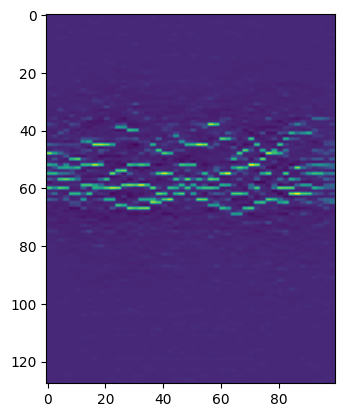

In [66]:
model.eval()
with torch.no_grad():
    _x = x.float().to(device)
    _x_hat, mean, log_var = model(_x)

_x_hat = _x_hat.cpu().numpy()[2, 0, :, :]
print(x_hat.shape)
plt.imshow(_x_hat)

# Generating new Samples from Latent Space

In [67]:
def generate_sample(z_sample): # 8, 8, 16
    # z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model.decode(z_sample)
    sample = x_decoded.detach().cpu().reshape(128, 100) # reshape vector to 2d array
    plt.imshow(sample)
    plt.axis('off')
    plt.show()
    return sample

In [ ]:
latent_vector = torch.rand(8, 8, 16).to(device)
generate_sample(latent_vector)

# Generating Samples from learned Distribution

In [68]:
def generate_sample_distr(z_sample): # 8, 8, 16
    # z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model.decode(z_sample)
    sample = x_decoded.detach().cpu().reshape(128, 100) # reshape vector to 2d array
    plt.imshow(sample)
    plt.axis('off')
    plt.show()
    return sample

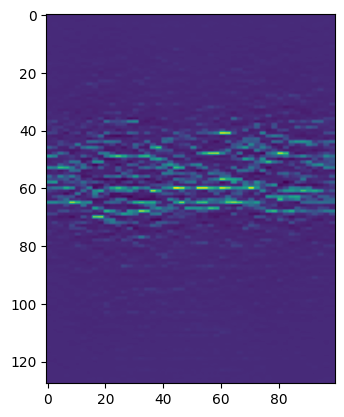

In [151]:
with torch.no_grad():
    mean = torch.randn(1, 32).to(device)*-0.1
    logvar = torch.randn(1, 32).to(device)*0.3
    z = model.module.reparameterization(mean, logvar)
    z = model.module.ztodec(z)
    z = z.view(z.shape[0], 8, 8, 16)
    new_sample = model.module.decode(z)

new_sample = new_sample.cpu().numpy()[0, 0, :, :]

plt.imshow(new_sample)

### Per quanto è ancora molto basilare è promettente (credo)

In [ ]:
torch.save(model.state_dict(), "BachVAE1.pt")


In [ ]:
model.load_state_dict(torch.load("/kaggle/working/BachVAE1.pt", weights_only=True))
model.eval()